# Model Interpretation
* **Author**: Winnie Zhang
* BrainStation, Data Science
* Previous notebook: 4. Modelling

## Introduction

In the previous notebook, we fitted different models using 2 different ways to represent the text: TF-IDF and Bag of Words. We concluded that TF-IDF Logistic Regression (L1 regularization) gave the best performing model.

In this notebook, I will further explore and interpret this model.
1. What is the precision and recall of this model? How many false positives and false negatives are there?
2. Which review words positively or negatively influence the sentiment of board game ratings?
3. Which description words positively or negatively influence the sentiment of board game ratings?
4. Which other features of board games positively or negatively influuence the sentiment of board game ratings?

First, I will load in the libaries and our best model.

In [1]:
import joblib
import pandas as pd

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt 
import seaborn as sns

Next, I will load best model:

In [2]:
best_model = joblib.load("models/grid_search_tfidf_l1_nopca.pkl")

I will take a look at the best estimator of the model:

In [3]:
best_model.best_estimator_

Pipeline(steps=[('scaling',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['boardgameexpansion',
                                                   'boardgameimplementation',
                                                   'Card Game', 'Wargame',
                                                   'Fantasy', 'Party Game',
                                                   'Dice', 'Science Fiction',
                                                   'Fighting',
                                                   "Children's Game",
                                                   'Abstract Strategy',
                                                   'Economic', 'Animals',
                                                   'World War II', 'Bluffing',
                                                   'Humor', 'Adventure',
                                                   'Deduction', 'Miniatures',
        

- C should be set to 1 and the regularization used should be L1.

## Confusion Matrix
I will now try to interpret more about this model. I will load in the X_train and X_test for TF-IDF and y_train and y_test so we can look at the confusion matrix, as well create a dataframe to interpret the highest and lowest coefficients.

In [4]:
X_train_tfidf = joblib.load("train_test_split/X_train_tfidf.pkl")
X_test_tfidf = joblib.load("train_test_split/X_test_tfidf.pkl")
y_train = joblib.load("train_test_split/y_train.pkl")
y_test = joblib.load("train_test_split/y_test.pkl")

I will now look at accuracy score this model again. 

In [5]:
print("Score:", best_model.score(X_test_tfidf, y_test))

Score: 0.7752663868259606


The accuracy of the model is 77.5%.

I also want to take a look at the confusion matrix of this model to understand more about the false negatives and false positives.

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


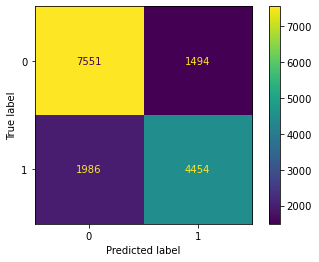

In [6]:
plot_confusion_matrix(best_model, X_test_tfidf, y_test)

Of the 9500 that the model predicts to be 0 (negative sentiment), 1986 were actually labelled as 1 (True Good). Of the 6000 predicted to be good, 1494 were actually bad, suggesting that the error rate for predicting a True Good is higher than a True Bad.

### Precision and Recall

I will now calculate precision and recall scores.

In [7]:
y_pred =  best_model.predict(X_test_tfidf)

In [8]:
precision_score(y_test, y_pred)

0.7488231338264963

The precision score 74.9%, meaning that when a new datapoint is classified as positive (good review), we can be 74.9% confident that it actually belongs to that class. 

Next, I will calculate the Recall score.

In [9]:
# recall_score(true labels, predicted labels)
recall_score(y_test, y_pred)

0.6916149068322981

The recall score 9s only 69.2%. This means that a new datapoint has a 69.2% chance to be correctly found by the model.

## Model Interpretation

First, I want to extract all the features and their coefficients. I will make this into a dataframe that I can better interpret and graph.

In [10]:
features = X_train_tfidf.columns.to_list()

df = pd.DataFrame({"feature": features, 
                   "Coefficient": best_model.best_estimator_.named_steps["model"].coef_[0]}).\
                        sort_values("Coefficient", ascending=False)
df.head()

,feature,Coefficient
1973,review_partial,4.657038
898,review_express,3.674465
368,review_board game,3.582177
856,review_eventu,3.411664
1374,review_head,3.369441


However, this dataframe contains information about the boardgames, the descriptions, and reviews. I want to extract all of these into separate dataframes so I can interpret this information separately.

First, I will look at the rows that contains "reviews".

In [11]:
# only look at words that contain review_
review_words = df[df["feature"].str.contains("review_")]
review_words.head()

,feature,Coefficient
1973,review_partial,4.657038
898,review_express,3.674465
368,review_board game,3.582177
856,review_eventu,3.411664
1374,review_head,3.369441


### Top 20 Positive and Negative Coefficients for Reviews

Now, I will graph the top 20 and bottom 20 coefficients to see which words most likely affect the sentiment of the review.

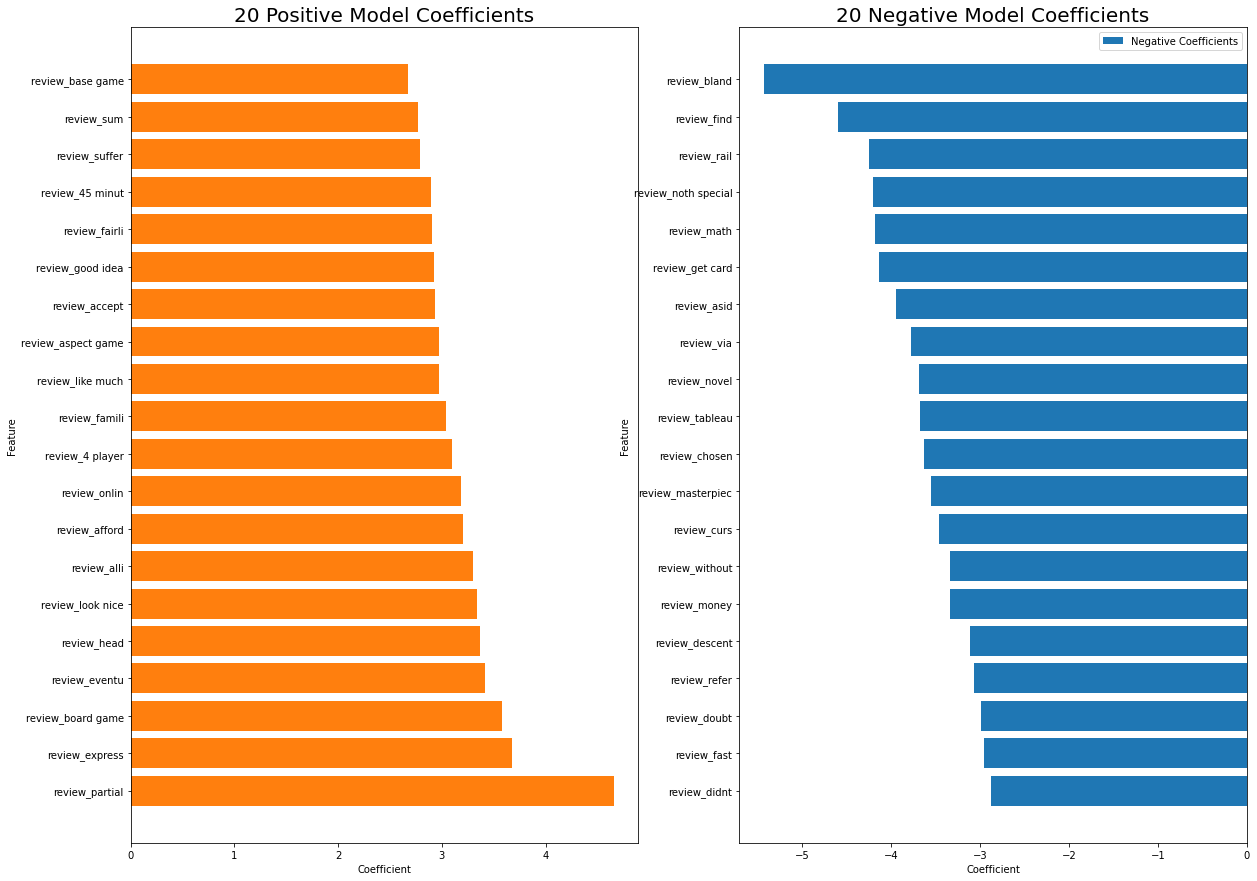

In [12]:
plt.subplots(1, 2, figsize=(20,15))
plt.subplot(1, 2, 1)
plt.title('20 Positive Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(review_words['feature'].head(20), 
         review_words['Coefficient'].head(20), label='Positive Coefficients', color='tab:orange')
plt.subplot(1, 2, 2)
plt.title('20 Negative Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(review_words['feature'].tail(20),
         review_words['Coefficient'].tail(20), label='Negative Coefficients')
plt.legend()
plt.show()

Key Negative Coefficients: 
- Bland
- Nothing Special
- Tableau- a type of boardgame where players have a tableau of components (cards, tiles, player boards) which they build or manipulate throughout the game. 
- Get card
- Math
- Money
- Fast 

Based on this, people don't seem to like games involving cards, math, or money. They also don't like games that pass by too quickly.

Key Positive Coeffients
- Looks nice
- Affordable
- Online
- Family 
- 4 player 

People tend to have a more positive sentiment towards games that are more aesthetically pleasing and aren't too expensive. They also like board games that are social, allowing them to play it online, or the whole family or a group of friends can play together.

### Top 20 Positive and Negative Coefficients for Reviews
Now, I will look at the description words.

In [13]:
# only look at words that contain descrip_
description_words = df[df["feature"].str.contains("descrip_")]
description_words.head()

,feature,Coefficient
3766,descrip_deck,2.712428
5205,descrip_rank,2.014158
3354,descrip_betray,1.962116
5751,descrip_token,1.706181
4215,descrip_game mani,1.676212


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


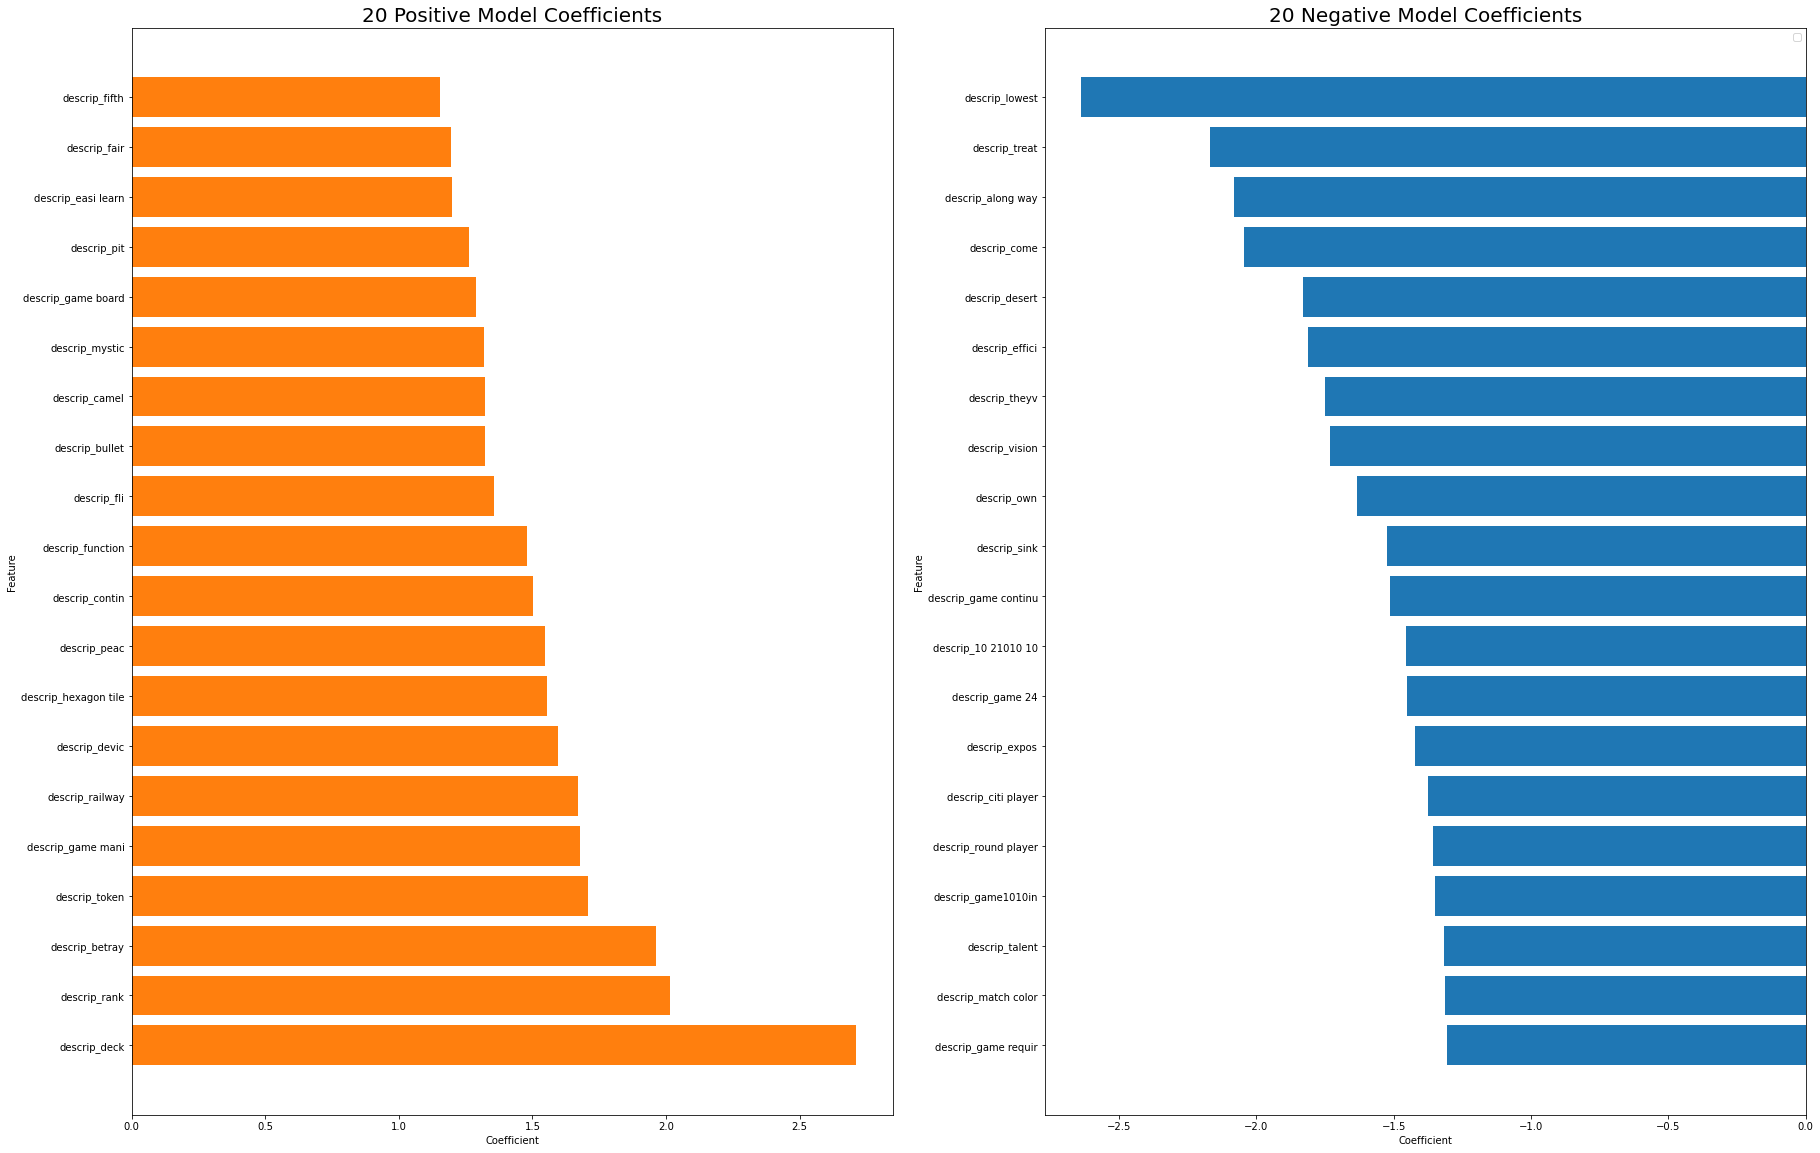

In [14]:
plt.subplots(1, 2, figsize=(30,20))
plt.subplot(1, 2, 1)
plt.title('20 Positive Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(description_words['feature'].head(20), 
         description_words['Coefficient'].head(20), color='tab:orange')
plt.subplot(1, 2, 2)
plt.title('20 Negative Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(description_words['feature'].tail(20),
         description_words['Coefficient'].tail(20))
plt.legend()
plt.show()

Notable Negative Coefficeints
- desert
- match color 

Notable Positive Coefficients
- Betray
- Mystic
- Easi learn 

Based on this, it seems that people don't like games located in the desert or include matching colours.

Games that involve betrayal, are mystical, and are easy to learn are popular with players.

### Other Features

Now, I will look at the features that aren't part of the `review` or `description.

In [15]:
# remove review_
features = df[~df["feature"].str.contains("review_")]
features.head()

,feature,Coefficient
3766,descrip_deck,2.712428
5205,descrip_rank,2.014158
28,Economic,1.995500
3354,descrip_betray,1.962116
5751,descrip_token,1.706181


In [16]:
# remove descrip
features = features[~features["feature"].str.contains("descrip_")]
features.head()

,feature,Coefficient
28,Economic,1.995500
39,Players: Two Player Only Games,0.811191
38,Medieval,0.630135
32,Humor,0.451146
5,minage,0.163292


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


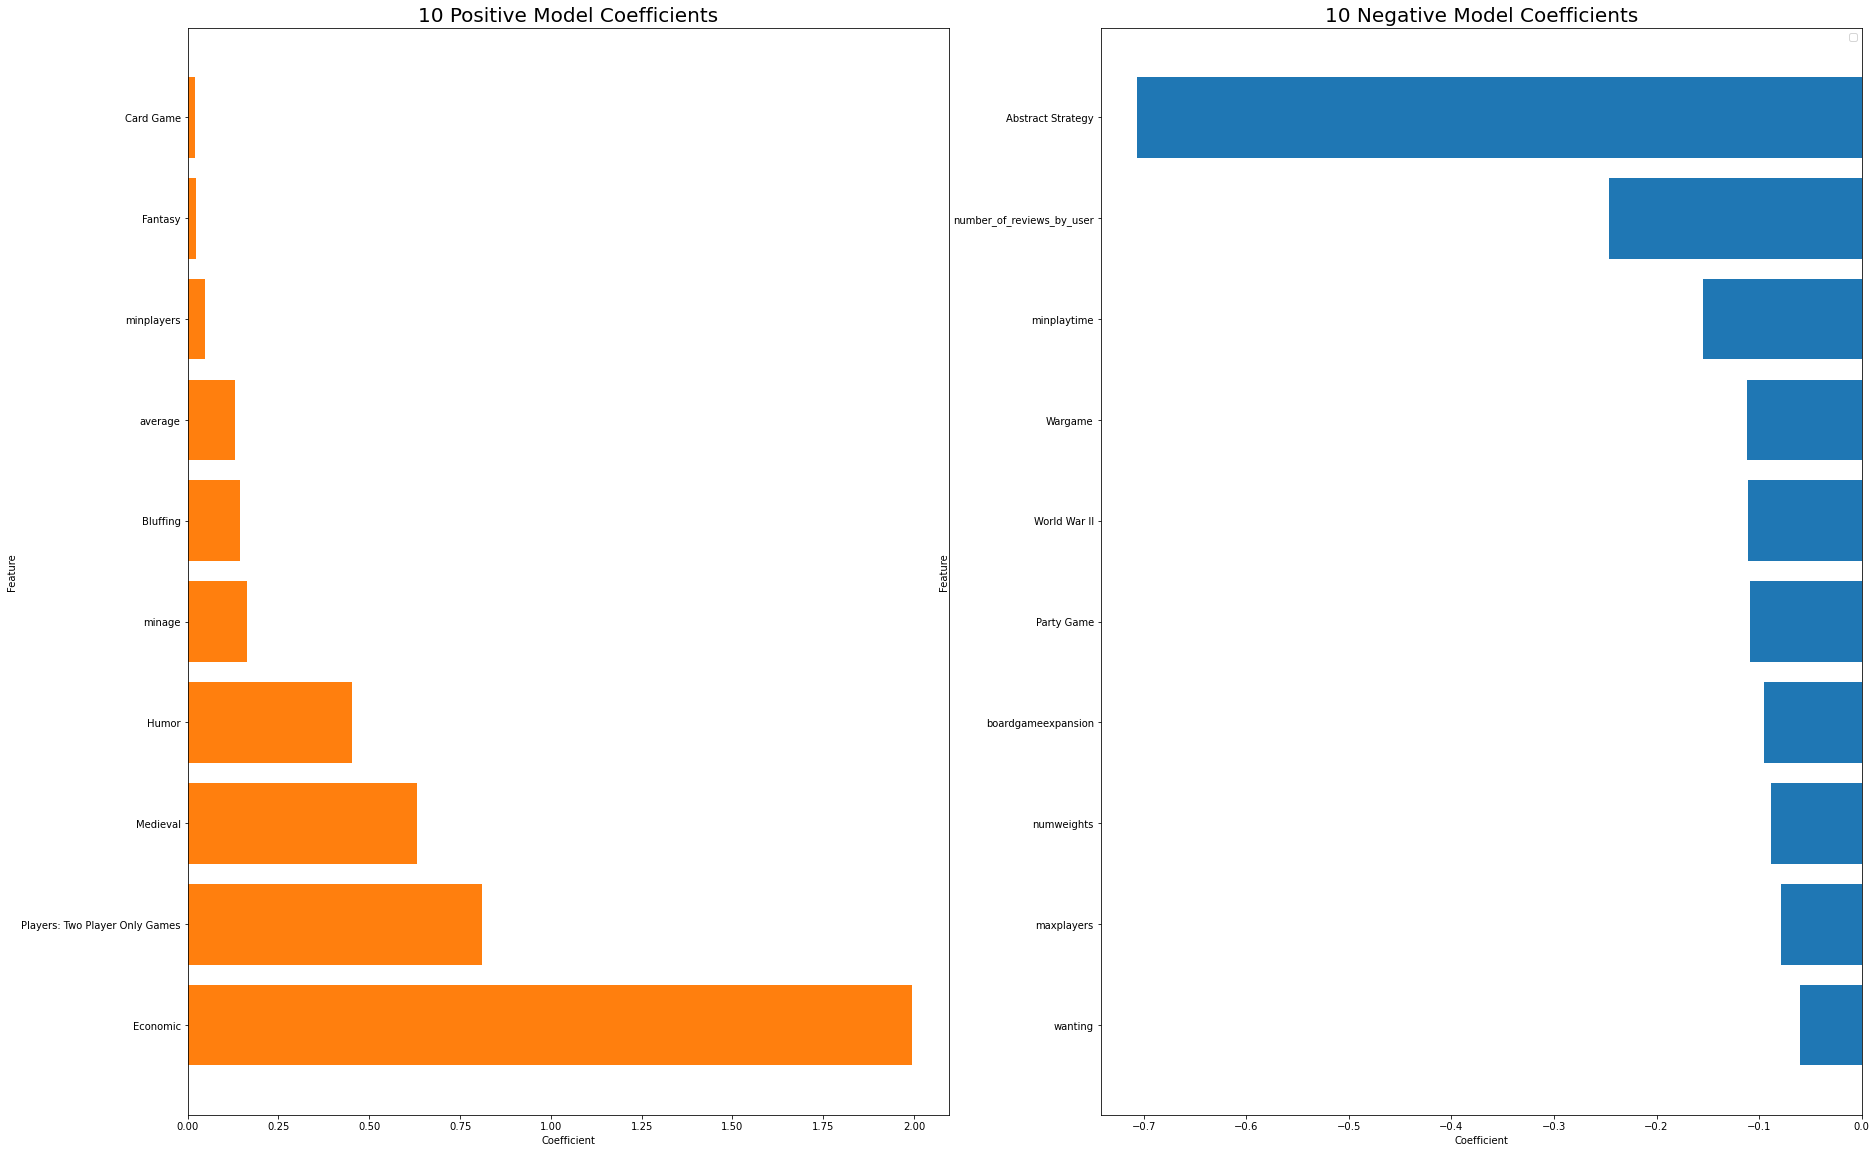

In [19]:
plt.subplots(1, 2, figsize=(30,20))
plt.subplot(1, 2, 1)
plt.title('10 Positive Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(features['feature'].head(10), 
         features['Coefficient'].head(10), color='tab:orange')
plt.subplot(1, 2, 2)
plt.title('10 Negative Model Coefficients', fontsize=20)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.barh(features['feature'].tail(10),
         features['Coefficient'].tail(10))
plt.legend()
plt.show()

Notable Negative Coefficients
- Abstract strategy

Based on this, abstract strategy plays a large part in resulting in a negative sentiment towards a game.

Notable Positive Coefficients 
- Economic

On the other hand, Economic themed games seem to have a positive effect. THis is surprising as earlier, we saw that `money` has a negative coefficient, suggesting that money results in negative sentiments.


## Conclusion

In this study, we trained a model that can predict whether the review a user gives a board game is positive or negative in sentiment with an accuracy of 77.5%. We have also identified the features that have the biggest influence on rating score. Creating a game that's easy to learn and is good looking is essential for a positive sentiment, without too much math or boring concepts like color matching. The board game should be catered towards families or groups of 4.

## Next Steps
The next steps I would take are:
-	Use more hyperparameters for the SVM. This is a computationally expensive model, so I didn’t try out a lot of hyperparameters when optimizing it. 
-	Use XGBoost to further improve the model for better prediction and interpret this model
-	Use neural networks and word2vec to see if this improves the modelling 